**about the data:**

The Cats vs Dogs dataset consists of thousands of color images of cats and dogs labeled accordingly. Originally released as part of a Kaggle competition by Microsoft Research, the dataset contains about 25,000 images (12,500 cats and 12,500 dogs). It is commonly used for binary image classification tasks and deep learning projects involving convolutional neural networks (CNNs).

##To run on your Drive:##
1. Open the link https://drive.google.com/drive/folders/1o5U5YFqx3LWWTJeCUWIQ5h3Fd6XeIk0M?usp=sharing
2. Add a shortcut to MyDrive on your personal Drive
3. Run the notebook

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls  /content/gdrive/MyDrive/cats_dogs

Mounted at /content/gdrive
test  train  Validation


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
import gc  # For garbage collection


In [ ]:
# Enable memory growth to prevent TF from grabbing all GPU memory at once
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled")
    except:
        print("Memory growth can't be enabled")


Memory growth enabled


In [ ]:
# Define paths
base_dir = "/content/gdrive/MyDrive/cats_dogs"
sets = ["train", "Validation", "test"]
categories = ["Cat", "Dog"]

# Increase if the memory allows
TRAIN_SIZE = 500  # Up from 100
VAL_SIZE = TRAIN_SIZE // 5  # 100 images
TEST_SIZE = TRAIN_SIZE // 5  # 100 images
IMG_SIZE = (224, 224)  # Standard size for many CNNs


In [ ]:
#to prepering the data
#-------------------------------------------------------------------------------
# Function to get a random subset of image paths
def get_image_paths(set_name, category, subset_size):
    category_path = os.path.join(base_dir, set_name, category)
    all_images = os.listdir(category_path)
    selected_images = random.sample(all_images, min(subset_size, len(all_images)))
    return [os.path.join(category_path, img) for img in selected_images]
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Function to load and preprocess a single image - with memory optimization
def load_and_preprocess_image(img_path, datagen=None, apply_augmentation=False):
    try:
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)

        if apply_augmentation and datagen is not None:
            img = datagen.random_transform(img)

        # Normalize
        img = img / 255.0
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        # Return a blank image as fallback
        return np.zeros(IMG_SIZE + (3,), dtype=np.float32)
#-------------------------------------------------------------------------------

# prapering pairs
#-------------------------------------------------------------------------------
# Improved Siamese dataset creation with better pair generation
def create_improved_siamese_dataset(image_paths, batch_size=16, datagen=None, is_training=True):
    categories = list(image_paths.keys())

    def generate_balanced_pairs():
        # Shuffle image paths to ensure different pairs each time
        cat_images = list(image_paths["Cat"])
        dog_images = list(image_paths["Dog"])

        random.shuffle(cat_images)
        random.shuffle(dog_images)

        # Determine number of pairs to generate
        if is_training:
            max_pairs_per_category = min(len(cat_images), len(dog_images), 50)
        else:
            max_pairs_per_category = min(len(cat_images), len(dog_images), 20)

        cat_sample = cat_images[:max_pairs_per_category]
        dog_sample = dog_images[:max_pairs_per_category]

        # List to hold all pairs and labels
        all_pairs = []
        all_labels = []

        # Generate SAME CLASS pairs (50%)
        # Cat-Cat pairs
        for i in range(max_pairs_per_category):
            # Don't use the same image with itself
            cat1 = cat_sample[i]
            remaining_cats = [c for c in cat_sample if c != cat1]
            if remaining_cats:
                cat2 = random.choice(remaining_cats)
                all_pairs.append((cat1, cat2))
                all_labels.append(0)  # Same class

        # Dog-Dog pairs
        for i in range(max_pairs_per_category):
            # Don't use the same image with itself
            dog1 = dog_sample[i]
            remaining_dogs = [d for d in dog_sample if d != dog1]
            if remaining_dogs:
                dog2 = random.choice(remaining_dogs)
                all_pairs.append((dog1, dog2))
                all_labels.append(0)  # Same class

        # Generate DIFFERENT CLASS pairs (50%)
        # Cat-Dog pairs
        for i in range(max_pairs_per_category * 2):  # Double the different class pairs
            cat = random.choice(cat_sample)
            dog = random.choice(dog_sample)
            all_pairs.append((cat, dog))
            all_labels.append(1)  # Different class

        # Shuffle all pairs
        combined = list(zip(all_pairs, all_labels))
        random.shuffle(combined)
        all_pairs, all_labels = zip(*combined)

        # Generate and yield pairs
        for (img1_path, img2_path), label in zip(all_pairs, all_labels):
            if is_training and datagen is not None:
                # Apply same augmentation to same-class pairs for consistency
                if label == 0:  # Same class
                    seed = np.random.randint(1000000)

                    np.random.seed(seed)
                    img1 = load_and_preprocess_image(img1_path, datagen, True)

                    np.random.seed(seed)
                    img2 = load_and_preprocess_image(img2_path, datagen, True)
                else:
                    # Different augmentation for different class pairs
                    img1 = load_and_preprocess_image(img1_path, datagen, True)
                    img2 = load_and_preprocess_image(img2_path, datagen, True)
            else:
                img1 = load_and_preprocess_image(img1_path)
                img2 = load_and_preprocess_image(img2_path)

            yield (img1, img2), label

    # Define output signature for the dataset
    output_signature = (
        (
            tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    # Create dataset with improved generation
    dataset = tf.data.Dataset.from_generator(
        generate_balanced_pairs,
        output_signature=output_signature
    )

    # Process dataset with memory optimizations
    dataset = dataset.map(lambda x, y: ((x[0], x[1]), y),
                         num_parallel_calls=tf.data.AUTOTUNE)

    # Use caching for validation/test to avoid reloading the same images
    if not is_training:
        # Calculate a reasonable number of examples to cache
        total_examples = max(min(len(image_paths["Cat"]) + len(image_paths["Dog"]), 200) * 2, 100)
        dataset = dataset.take(total_examples).cache()

    dataset = dataset.batch(batch_size)

    if is_training:
        dataset = dataset.shuffle(buffer_size=100)
        dataset = dataset.repeat()  # Repeat indefinitely for training

    # Prefetch for better performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # For steps calculation
    if is_training:
        steps = 50  # Fixed number of steps for training
    else:
        # For validation/test, use actual size
        steps = (len(image_paths["Cat"]) + len(image_paths["Dog"])) // batch_size

    return dataset, steps
#-------------------------------------------------------------------------------

In [ ]:
# Function to visualize image pairs from a dataset
def show_image_pairs_from_dataset(dataset, num=3):
    # Get a batch of data
    for (img1_batch, img2_batch), labels_batch in dataset.take(1):
        fig, axes = plt.subplots(min(num, len(labels_batch)), 2, figsize=(6, min(num, len(labels_batch)) * 3))

        for i in range(min(num, len(labels_batch))):
            axes[i, 0].imshow(img1_batch[i])
            axes[i, 0].axis("off")
            axes[i, 0].set_title("Image 1")

            axes[i, 1].imshow(img2_batch[i])
            axes[i, 1].axis("off")
            axes[i, 1].set_title(f"Match: {labels_batch[i] == 0}")

        plt.tight_layout()
        plt.show()
        break

In [ ]:
#distances
#-------------------------------------------------------------------------------
# Improved Distance Tracker Callback
class DistanceTracker(tf.keras.callbacks.Callback):
    def __init__(self, validation_dataset, num_batches=5):
        super().__init__()
        self.validation_dataset = validation_dataset
        self.num_batches = num_batches
        self.epoch_distances = []
        self.positive_distances = []  # Same category mean distances by epoch
        self.negative_distances = []  # Different category mean distances by epoch
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        # Collect epoch number
        self.epochs.append(epoch + 1)

        # Variables to store distances for this epoch
        epoch_pos_distances = []
        epoch_neg_distances = []

        # Process a limited number of batches from validation dataset
        for i, ((img1_batch, img2_batch), labels_batch) in enumerate(self.validation_dataset):
            if i >= self.num_batches:
                break

            # Get predictions (distances) from the model
            distances = self.model.predict([img1_batch, img2_batch], verbose=0)

            # Convert tensors to numpy arrays for easier processing
            labels = labels_batch.numpy()

            # Separate positive and negative pairs
            for j, label in enumerate(labels):
                if label == 0:  # Same category (positive pair)
                    epoch_pos_distances.append(distances[j][0])
                else:  # Different category (negative pair)
                    epoch_neg_distances.append(distances[j][0])

        # Calculate mean distances for this epoch
        mean_pos = np.mean(epoch_pos_distances) if epoch_pos_distances else 0
        mean_neg = np.mean(epoch_neg_distances) if epoch_neg_distances else 0

        # Store mean distances
        self.positive_distances.append(mean_pos)
        self.negative_distances.append(mean_neg)

        # Print for monitoring
        print(f"\nEpoch {epoch+1} - Mean distances: Positive = {mean_pos:.4f}, Negative = {mean_neg:.4f}, Separation = {mean_neg - mean_pos:.4f}")

        # Plot the current progress
        self.plot_distance_evolution()

        # Force garbage collection
        gc.collect()

    def plot_distance_evolution(self):
        """Plot the evolution of distances throughout training"""
        plt.figure(figsize=(10, 6))

        # Plot mean distances
        plt.plot(self.epochs, self.positive_distances, 'g-o', label='Same Category')
        plt.plot(self.epochs, self.negative_distances, 'r-o', label='Different Categories')

        # Add margin line if we have contrastive loss with margin
        plt.axhline(y=2.0, color='blue', linestyle='--', alpha=0.5, label='Margin')

        # Add labels and title
        plt.xlabel('Epoch')
        plt.ylabel('Mean Distance')
        plt.title('Siamese Network: Distance Evolution During Training')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Set y-axis to start from 0
        plt.ylim(bottom=0)

        # Add text showing current distance values
        if len(self.epochs) > 0:
            latest_epoch = self.epochs[-1]
            latest_pos = self.positive_distances[-1]
            latest_neg = self.negative_distances[-1]

            # Calculate separation (how well the model distinguishes between classes)
            separation = latest_neg - latest_pos

            # Add text annotation
            plt.annotate(f'Latest (Epoch {latest_epoch}):\n'
                        f'Same Category: {latest_pos:.4f}\n'
                        f'Different Categories: {latest_neg:.4f}\n'
                        f'Separation: {separation:.4f}',
                        xy=(0.02, 0.02),
                        xycoords='axes fraction',
                        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

        plt.tight_layout()
        plt.show()
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# IMPROVED: Proper Euclidean Distance Function
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# IMPROVED: Better contrastive loss function
def contrastive_loss(margin=1.5):
    def loss(y_true, y_pred):
        # Convert labels to float32 for calculations
        y_true = tf.cast(y_true, tf.float32)

        # Square of distances
        square_pred = tf.square(y_pred)

        # Calculate loss for similar pairs (y_true=0): want distances to be small
        similar_pair_loss = (1 - y_true) * square_pred

        # Calculate loss for dissimilar pairs (y_true=1): want distances to be larger than margin
        dissimilar_pair_loss = y_true * tf.square(tf.maximum(margin - y_pred, 0))

        # Combine both components with equal weight
        return tf.reduce_mean(similar_pair_loss + dissimilar_pair_loss)

    return loss
#-------------------------------------------------------------------------------

In [ ]:
# IMPROVED: Better Siamese network architecture with L2 normalization
def build_siamese_network(input_shape):
    # Use DenseNet121 for better feature extraction
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Fine-tuning strategy: freeze early layers, train later layers
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Make later layers trainable for fine-tuning
    for layer in base_model.layers[100:]:
        layer.trainable = True

    input = keras.layers.Input(input_shape)
    x = base_model(input)
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Add more expressive layers with regularization
    x = keras.layers.Dense(512, activation="relu",
                          kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)  # Increased dropout

    # Add another layer for better feature learning
    x = keras.layers.Dense(256, activation="relu",
                          kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)


    # Final embedding layer with L2 normalization - crucial for distance metrics
    embedding = keras.layers.Dense(128, activation=None,
                                  kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    embedding_normalized = keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(embedding)


    return keras.Model(input, embedding_normalized)


In [ ]:
#train
#-------------------------------------------------------------------------------
# Create custom early stopping based on distance separation
class DistanceSeparationEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, patience=5, min_separation=0.5):
        super().__init__()
        self.val_dataset = val_dataset
        self.patience = patience
        self.min_separation = min_separation
        self.best_separation = -np.inf
        self.wait = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        positive_distances = []
        negative_distances = []

        # Evaluate on validation set
        for i, ((img1_batch, img2_batch), labels_batch) in enumerate(self.val_dataset):
            if i >= 5:  # Limit to 5 batches for efficiency
                break

            # Get distances
            distances = self.model.predict([img1_batch, img2_batch], verbose=0)

            # Separate by label
            for j, label in enumerate(labels_batch):
                if label == 0:  # Same class
                    positive_distances.append(distances[j][0])
                else:  # Different class
                    negative_distances.append(distances[j][0])

        # Calculate means and separation
        mean_positive = np.mean(positive_distances) if positive_distances else 0
        mean_negative = np.mean(negative_distances) if negative_distances else 0
        separation = mean_negative - mean_positive

        # Print current separation
        print(f"\nEpoch {epoch+1}: Separation = {separation:.4f}, "
              f"Pos = {mean_positive:.4f}, Neg = {mean_negative:.4f}")

        # Check if this is the best separation so far
        if separation > self.best_separation:
            self.best_separation = separation
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print(f"Early stopping: Separation hasn't improved for {self.patience} epochs")
                if self.best_weights is not None:
                    self.model.set_weights(self.best_weights)
                    print(f"Restoring model weights from best separation: {self.best_separation:.4f}")
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Create learning rate schedule with warm-up
def create_lr_schedule():
    initial_learning_rate = 1e-4

    # Learning rate warm-up for first 3 epochs
    def warmup_cosine_decay(epoch, lr):
        warmup_epochs = 3
        total_epochs = EPOCHS
        warmup_lr = initial_learning_rate * 0.1  # Start with lower LR

        if epoch < warmup_epochs:
            # Linear warm up
            return warmup_lr + (initial_learning_rate - warmup_lr) * (epoch / warmup_epochs)
        else:
            # Cosine decay
            progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            return initial_learning_rate * (0.5 * (1 + np.cos(np.pi * progress)))

    return tf.keras.callbacks.LearningRateScheduler(warmup_cosine_decay)
#-------------------------------------------------------------------------------



In [ ]:
# Function to visualize training history
def plot_training_history(history):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

#-------------------------------------------------------------------------------
# Function to visualize test predictions with distances
def show_test_predictions(dataset, model, num=5):
    for (img1_batch, img2_batch), labels_batch in dataset.take(1):
        # Get predictions (distances)
        distances = model.predict([img1_batch, img2_batch], verbose=0)

        # Visualize
        fig, axes = plt.subplots(min(num, len(labels_batch)), 1.5, figsize=(8, min(num, len(labels_batch)) * 3))

        for i in range(min(num, len(labels_batch))):
            axes[i, 0].imshow(img1_batch[i])
            axes[i, 0].axis("off")
            axes[i, 0].set_title("Image 1")

            axes[i, 1].imshow(img2_batch[i])
            axes[i, 1].axis("off")

            # Label based on distance
            category = "Same Category" if labels_batch[i] == 0 else "Different Category"
            axes[i, 1].set_title(f"{category}, Distance: {distances[i][0]:.4f}")

        plt.tight_layout()
        plt.show()
        break
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Function to visualize distance distribution
def plot_distance_distribution(dataset, model, num_batches=10):
    positive_distances = []
    negative_distances = []

    # Collect distances from multiple batches
    for i, ((img1_batch, img2_batch), labels_batch) in enumerate(dataset):
        if i >= num_batches:
            break

        # Get distances
        distances = model.predict([img1_batch, img2_batch], verbose=0)

        # Separate by label
        for j, label in enumerate(labels_batch):
            if label == 0:  # Same class
                positive_distances.append(distances[j][0])
            else:  # Different class
                negative_distances.append(distances[j][0])

    # Calculate statistics
    mean_positive = np.mean(positive_distances)
    mean_negative = np.mean(negative_distances)
    separation = mean_negative - mean_positive

    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(positive_distances, bins=30, alpha=0.5, label='Same Category')
    plt.hist(negative_distances, bins=30, alpha=0.5, label='Different Category')
    plt.axvline(x=mean_positive, color='green', linestyle='--', label=f'Same Mean: {mean_positive:.4f}')
    plt.axvline(x=mean_negative, color='red', linestyle='--', label=f'Different Mean: {mean_negative:.4f}')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title(f'Distance Distribution (Separation: {separation:.4f})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"Distance Separation Analysis:")
    print(f"  Mean Same Category Distance: {mean_positive:.4f}")
    print(f"  Mean Different Category Distance: {mean_negative:.4f}")
    print(f"  Separation: {separation:.4f}")
#-------------------------------------------------------------------------------

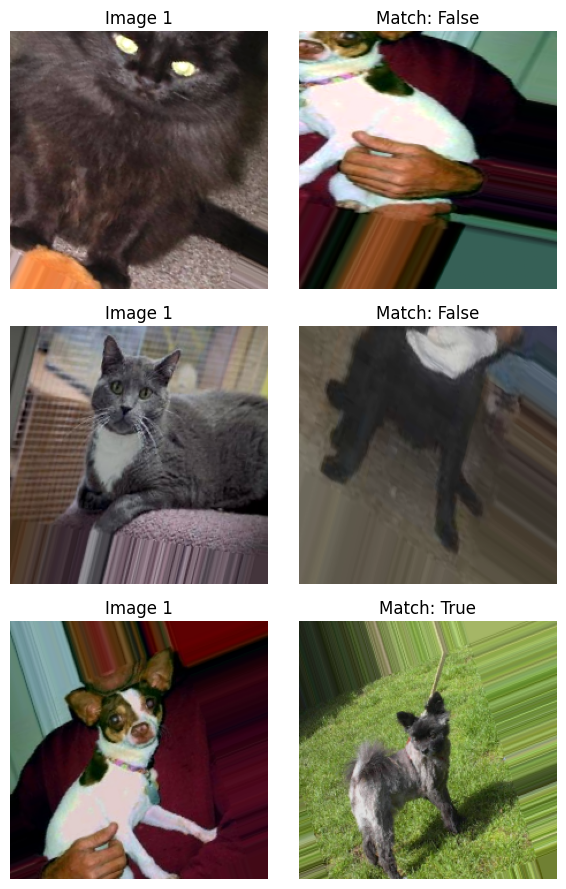

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  7,729,600 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,729,600 (29.49 MB)

 Trainable params: 6,839,744 (26.09 MB)

 Non-trainable params: 889,856 (3.39 MB)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4845 - loss: 1.1427

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: Separation = 0.0603, Pos = 1.2414, Neg = 1.3016

Epoch 1: val_loss improved from inf to 0.91848, saving model to best_siamese_model.h5



Epoch 1 - Mean distances: Positive = 1.2414, Negative = 1.3016, Separation = 0.0603


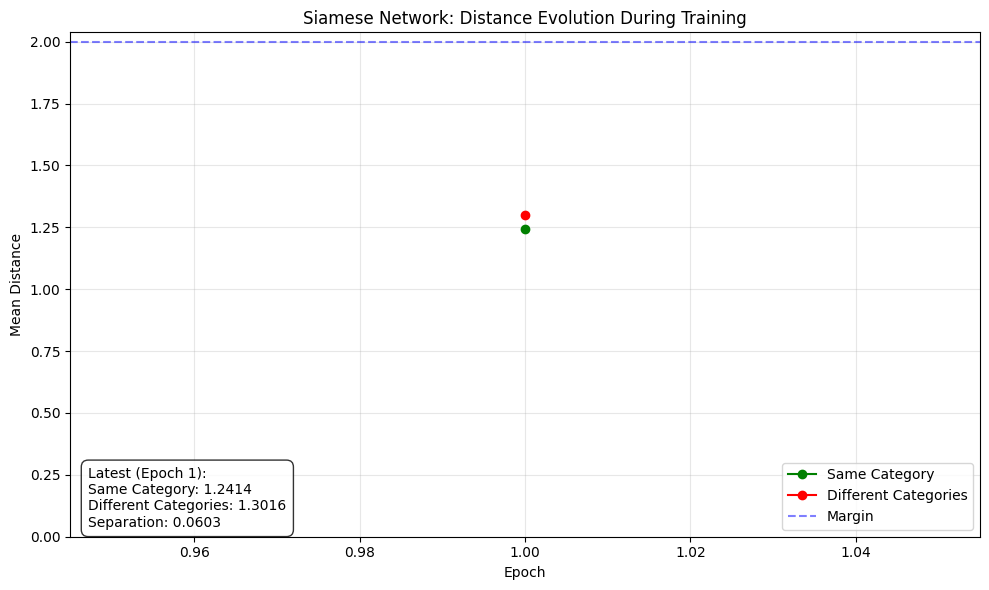

50/50 ━━━━━━━━━━━━━━━━━━━━ 597s 7s/step - accuracy: 0.4848 - loss: 1.1423 - val_accuracy: 0.5000 - val_loss: 0.9185 - learning_rate: 1.0000e-05
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.5121 - loss: 1.0926
Epoch 2: Separation = 0.0926, Pos = 1.2669, Neg = 1.3595

Epoch 2: val_loss did not improve from 0.91848

Epoch 2 - Mean distances: Positive = 1.2669, Negative = 1.3595, Separation = 0.0926


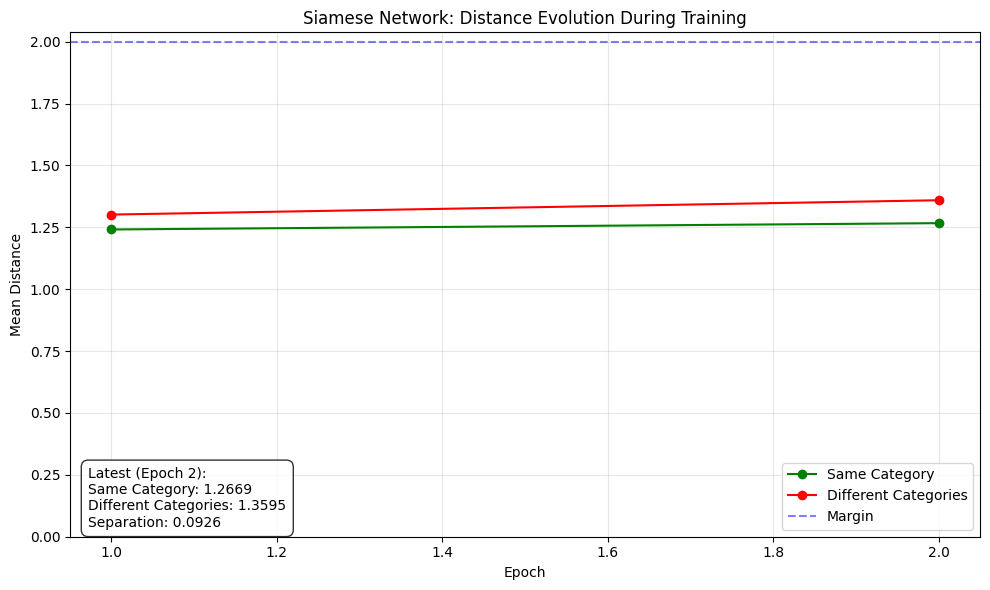

50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 982ms/step - accuracy: 0.5119 - loss: 1.0931 - val_accuracy: 0.5000 - val_loss: 0.9414 - learning_rate: 4.0000e-05
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.4990 - loss: 1.1334
Epoch 3: Separation = 0.1392, Pos = 1.2785, Neg = 1.4177

Epoch 3: val_loss did not improve from 0.91848

Epoch 3 - Mean distances: Positive = 1.2785, Negative = 1.4177, Separation = 0.1392


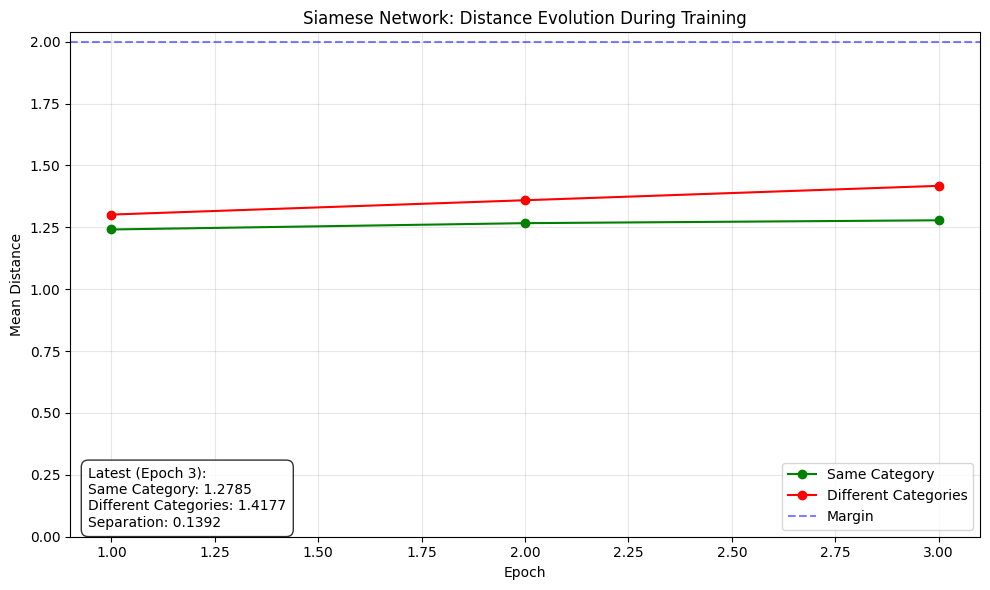

50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 999ms/step - accuracy: 0.4992 - loss: 1.1327 - val_accuracy: 0.5000 - val_loss: 0.9479 - learning_rate: 7.0000e-05
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.4670 - loss: 1.1724
Epoch 4: Separation = 0.2987, Pos = 1.1858, Neg = 1.4846

Epoch 4: val_loss improved from 0.91848 to 0.82666, saving model to best_siamese_model.h5



Epoch 4 - Mean distances: Positive = 1.1858, Negative = 1.4846, Separation = 0.2987


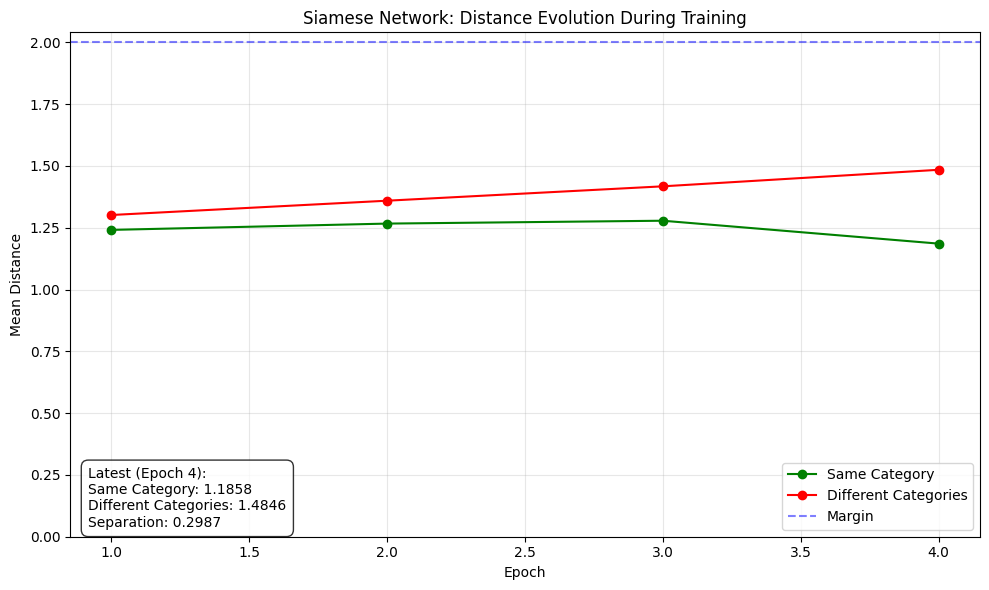

50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 969ms/step - accuracy: 0.4674 - loss: 1.1714 - val_accuracy: 0.5000 - val_loss: 0.8267 - learning_rate: 1.0000e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.5182 - loss: 1.0333
Epoch 5: Separation = 0.5421, Pos = 1.0669, Neg = 1.6091

Epoch 5: val_loss improved from 0.82666 to 0.69096, saving model to best_siamese_model.h5



Epoch 5 - Mean distances: Positive = 1.0669, Negative = 1.6091, Separation = 0.5421


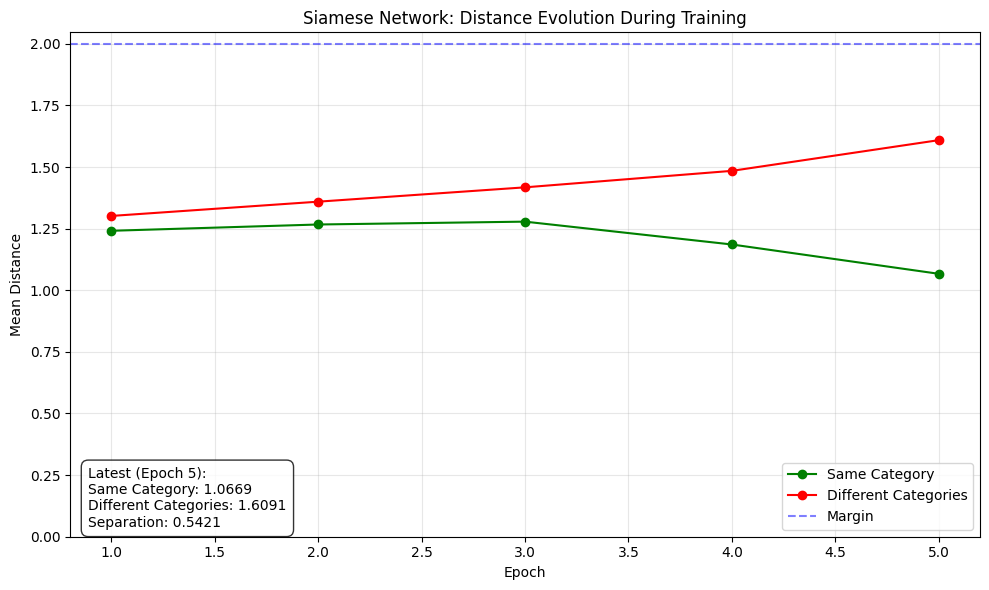

50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 820ms/step - accuracy: 0.5179 - loss: 1.0337 - val_accuracy: 0.5000 - val_loss: 0.6910 - learning_rate: 9.9662e-05
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.5106 - loss: 0.9691
Epoch 6: Separation = 0.8358, Pos = 0.8721, Neg = 1.7079

Epoch 6: val_loss improved from 0.69096 to 0.50955, saving model to best_siamese_model.h5



Epoch 6 - Mean distances: Positive = 0.8721, Negative = 1.7079, Separation = 0.8358


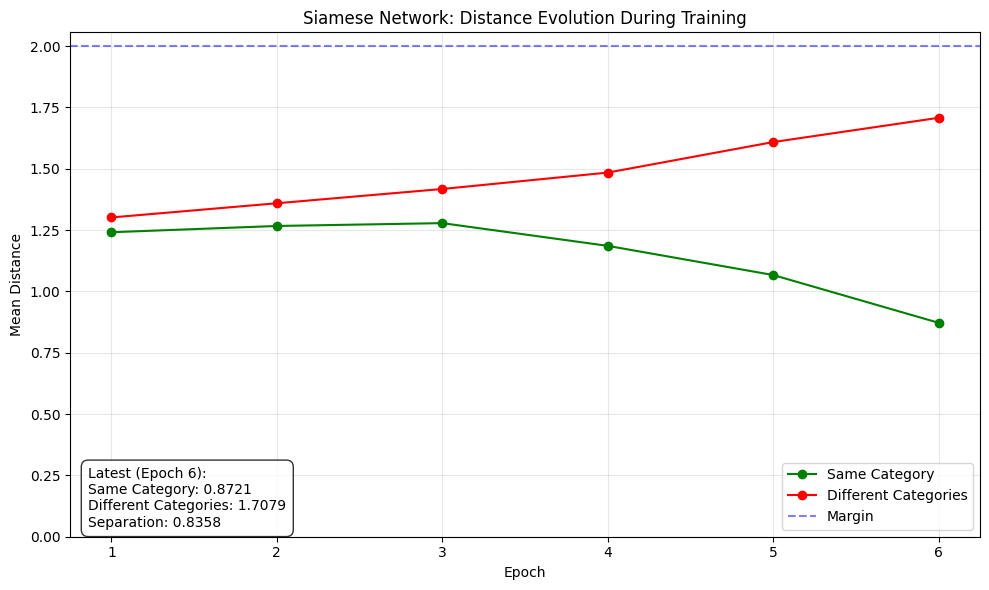

50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 808ms/step - accuracy: 0.5105 - loss: 0.9690 - val_accuracy: 0.5125 - val_loss: 0.5096 - learning_rate: 9.8652e-05
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.4890 - loss: 0.9264
Epoch 7: Separation = 1.0944, Pos = 0.7061, Neg = 1.8005

Epoch 7: val_loss improved from 0.50955 to 0.37831, saving model to best_siamese_model.h5



Epoch 7 - Mean distances: Positive = 0.7061, Negative = 1.8005, Separation = 1.0944


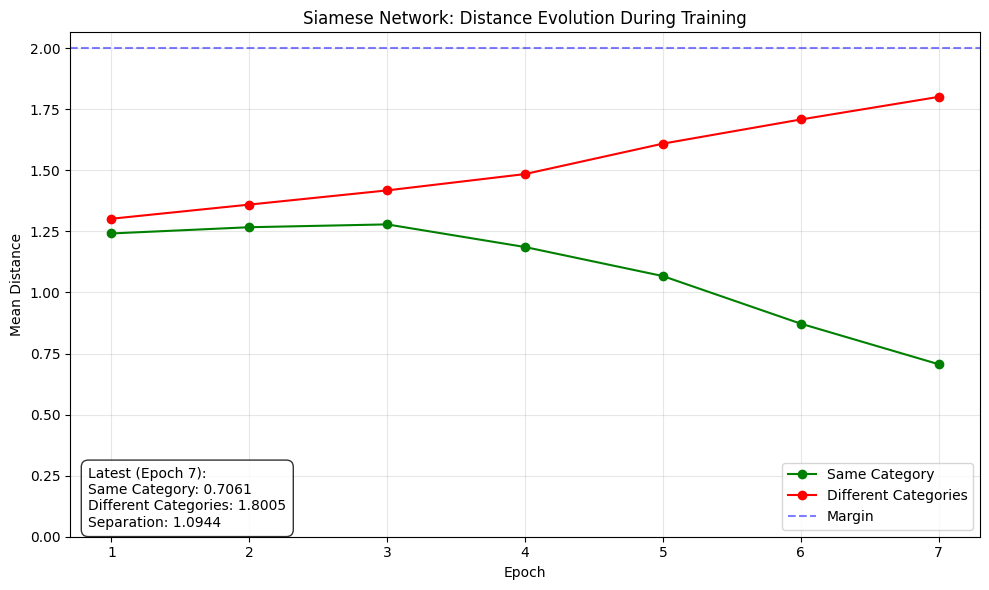

50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 700ms/step - accuracy: 0.4891 - loss: 0.9260 - val_accuracy: 0.5625 - val_loss: 0.3783 - learning_rate: 9.6985e-05
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.5089 - loss: 0.8537
Epoch 8: Separation = 1.2987, Pos = 0.5734, Neg = 1.8721

Epoch 8: val_loss improved from 0.37831 to 0.28131, saving model to best_siamese_model.h5



Epoch 8 - Mean distances: Positive = 0.5734, Negative = 1.8721, Separation = 1.2987


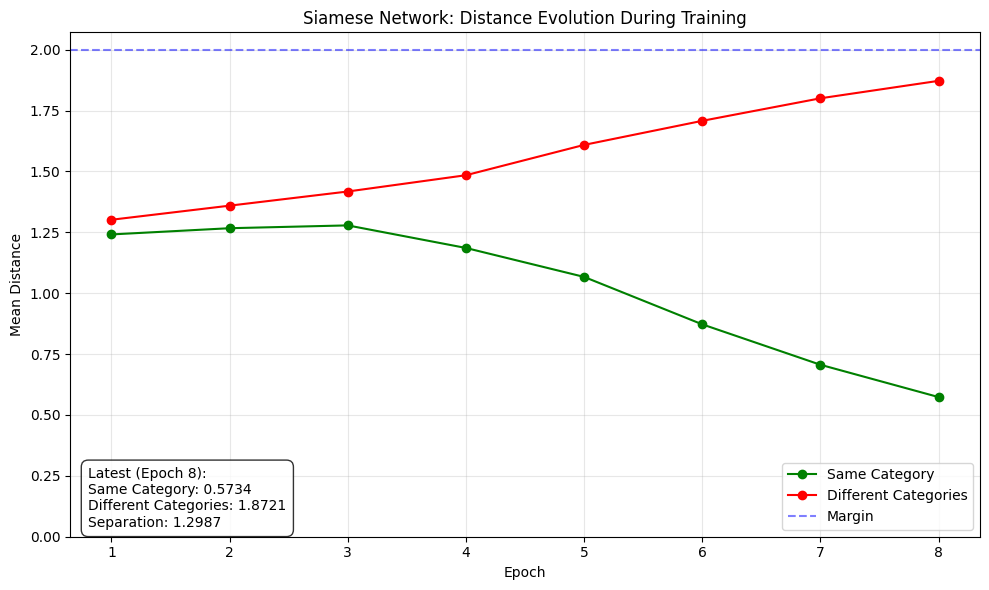

50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 698ms/step - accuracy: 0.5087 - loss: 0.8537 - val_accuracy: 0.6625 - val_loss: 0.2813 - learning_rate: 9.4682e-05
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.5037 - loss: 0.7641
Epoch 9: Separation = 1.4199, Pos = 0.4809, Neg = 1.9008

Epoch 9: val_loss improved from 0.28131 to 0.23010, saving model to best_siamese_model.h5



Epoch 9 - Mean distances: Positive = 0.4809, Negative = 1.9008, Separation = 1.4199


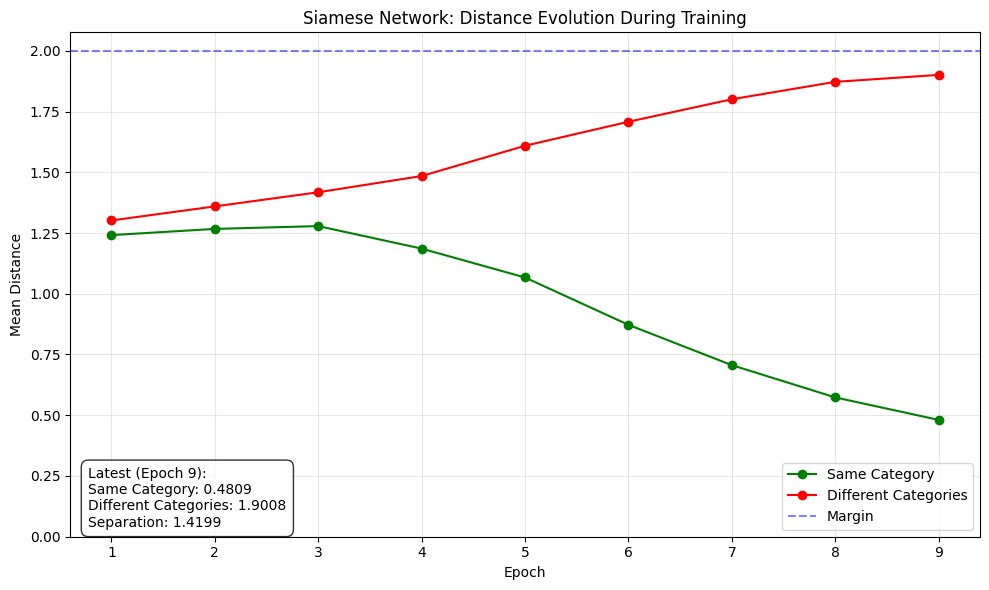

50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 788ms/step - accuracy: 0.5036 - loss: 0.7644 - val_accuracy: 0.8375 - val_loss: 0.2301 - learning_rate: 9.1774e-05
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.5070 - loss: 0.7819
Epoch 10: Separation = 1.4678, Pos = 0.4462, Neg = 1.9140

Epoch 10: val_loss improved from 0.23010 to 0.21176, saving model to best_siamese_model.h5



Epoch 10 - Mean distances: Positive = 0.4462, Negative = 1.9140, Separation = 1.4678


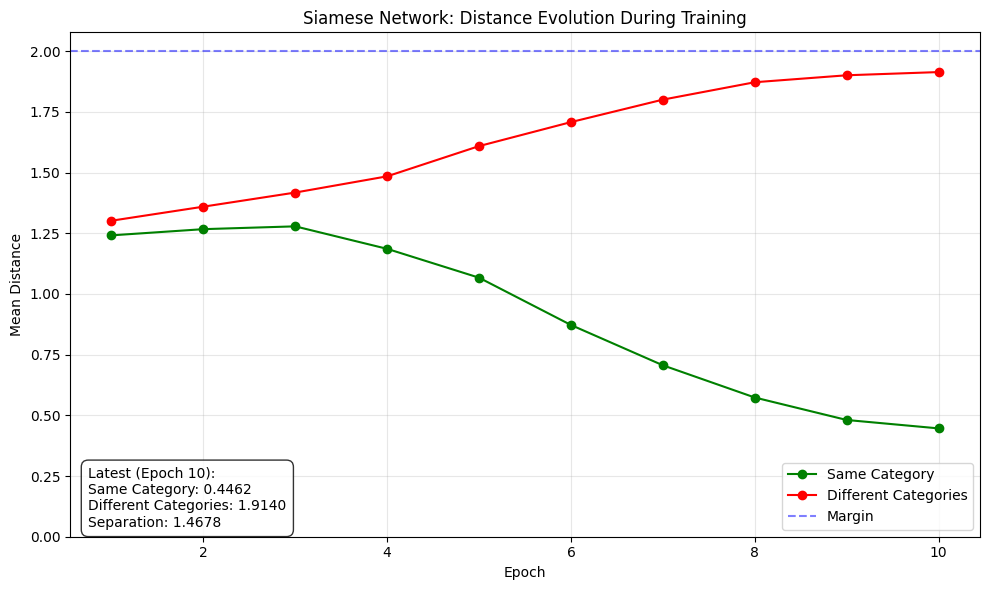

50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 755ms/step - accuracy: 0.5069 - loss: 0.7815 - val_accuracy: 0.9000 - val_loss: 0.2118 - learning_rate: 8.8302e-05
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.4917 - loss: 0.7501
Epoch 11: Separation = 1.2021, Pos = 0.5672, Neg = 1.7693

Epoch 11: val_loss did not improve from 0.21176

Epoch 11 - Mean distances: Positive = 0.5672, Negative = 1.7693, Separation = 1.2021


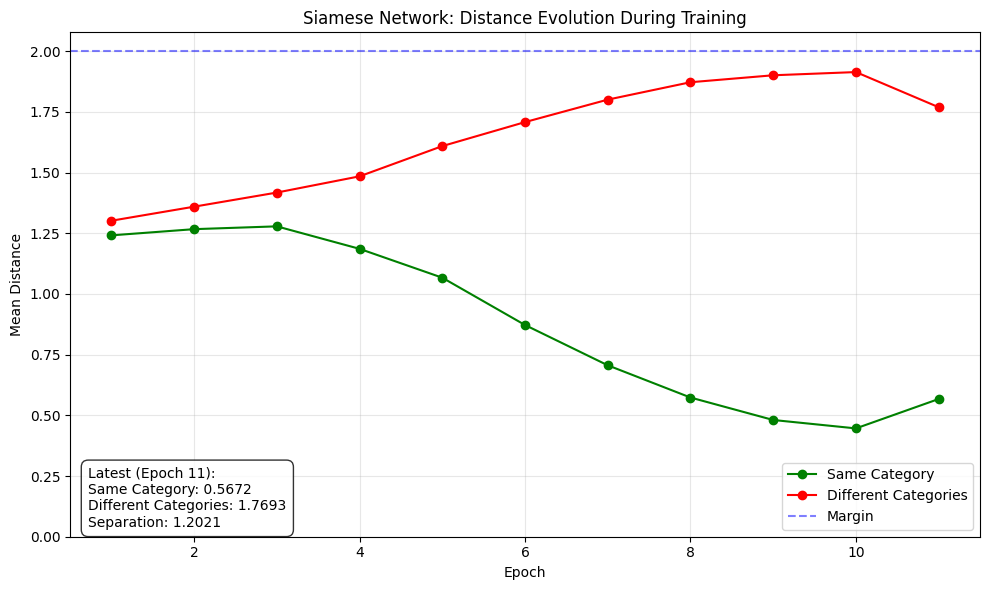

50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 606ms/step - accuracy: 0.4917 - loss: 0.7499 - val_accuracy: 0.8375 - val_loss: 0.3839 - learning_rate: 8.4312e-05
Epoch 12/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.5158 - loss: 0.7038
Epoch 12: Separation = 1.5674, Pos = 0.3582, Neg = 1.9256

Epoch 12: val_loss improved from 0.21176 to 0.16978, saving model to best_siamese_model.h5



Epoch 12 - Mean distances: Positive = 0.3582, Negative = 1.9256, Separation = 1.5674


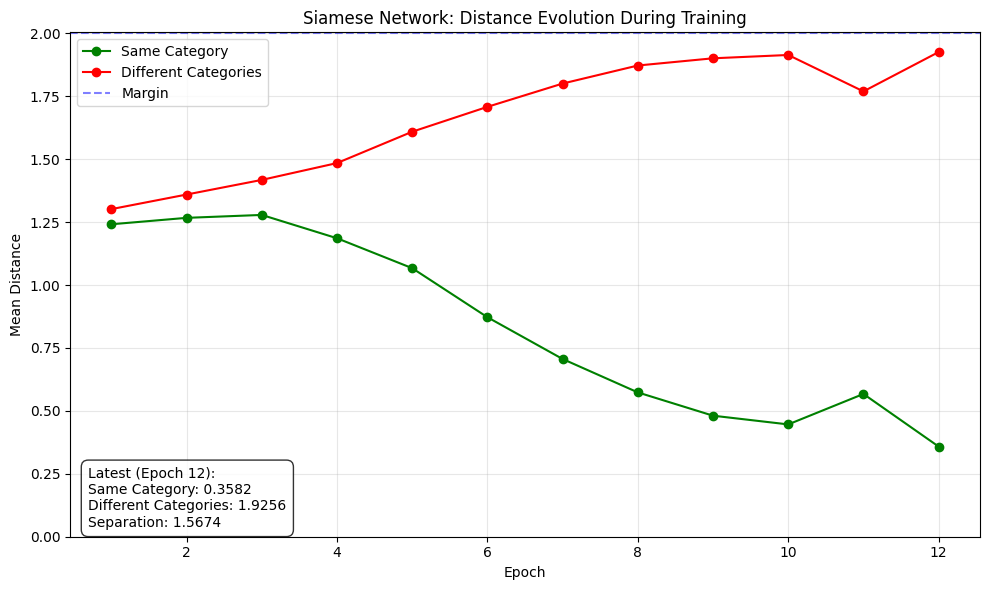

50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 748ms/step - accuracy: 0.5156 - loss: 0.7035 - val_accuracy: 0.9500 - val_loss: 0.1698 - learning_rate: 7.9858e-05
Epoch 13/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5208 - loss: 0.6513
Epoch 13: Separation = 1.5989, Pos = 0.3353, Neg = 1.9342

Epoch 13: val_loss improved from 0.16978 to 0.15716, saving model to best_siamese_model.h5



Epoch 13 - Mean distances: Positive = 0.3353, Negative = 1.9342, Separation = 1.5989


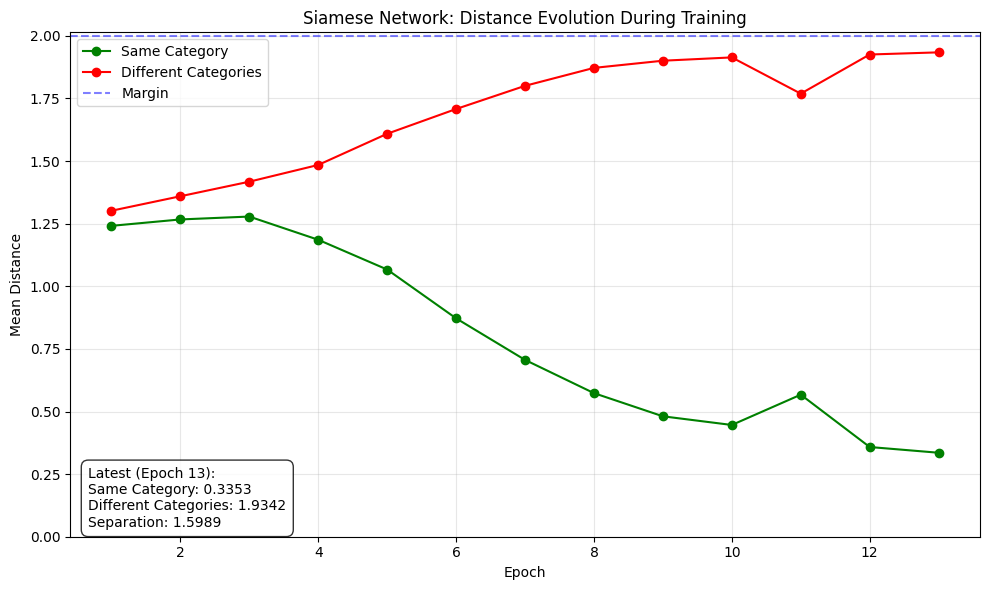

50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 651ms/step - accuracy: 0.5207 - loss: 0.6516 - val_accuracy: 1.0000 - val_loss: 0.1572 - learning_rate: 7.5000e-05
Epoch 14/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.4950 - loss: 0.6755
Epoch 14: Separation = 1.5867, Pos = 0.3380, Neg = 1.9246

Epoch 14: val_loss did not improve from 0.15716

Epoch 14 - Mean distances: Positive = 0.3380, Negative = 1.9246, Separation = 1.5867


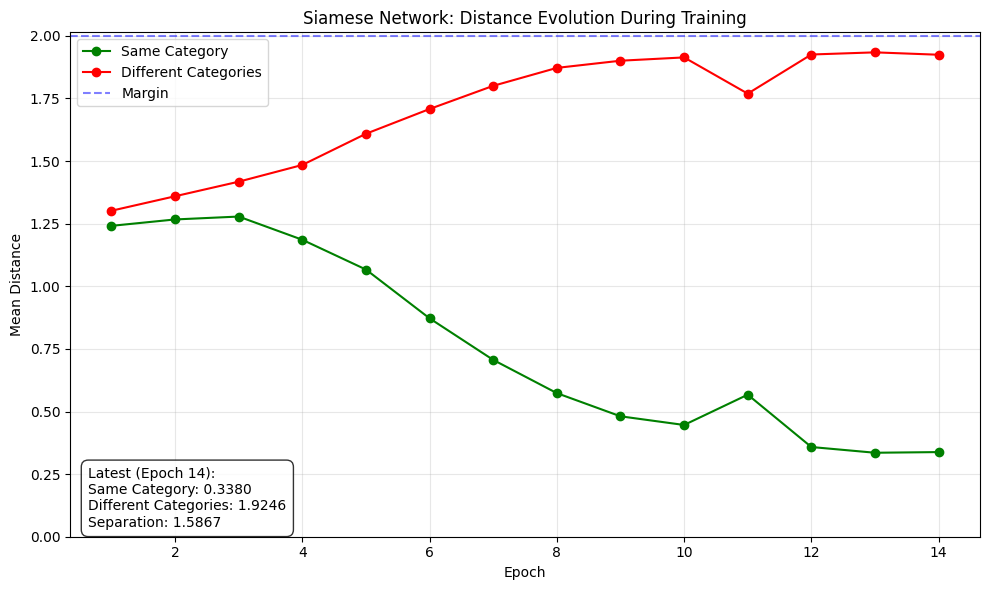

50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 644ms/step - accuracy: 0.4955 - loss: 0.6752 - val_accuracy: 0.9500 - val_loss: 0.1588 - learning_rate: 6.9804e-05
Epoch 15/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.5109 - loss: 0.6183
Epoch 15: Separation = 1.6109, Pos = 0.3166, Neg = 1.9276

Epoch 15: val_loss improved from 0.15716 to 0.15390, saving model to best_siamese_model.h5



Epoch 15 - Mean distances: Positive = 0.3166, Negative = 1.9276, Separation = 1.6109


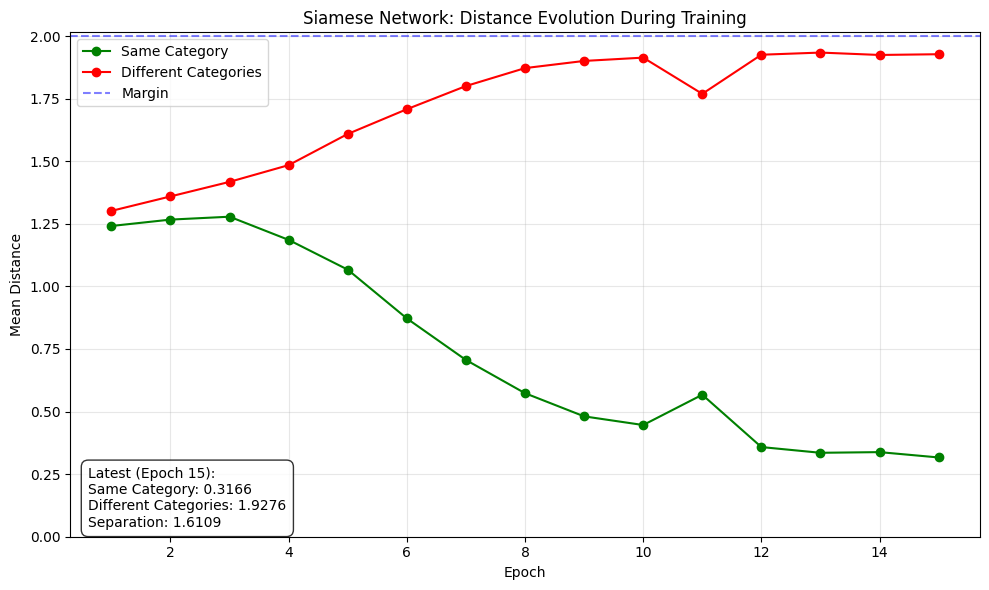

50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 774ms/step - accuracy: 0.5111 - loss: 0.6177 - val_accuracy: 0.9375 - val_loss: 0.1539 - learning_rate: 6.4340e-05
Epoch 16/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.5519 - loss: 0.5991
Epoch 16: Separation = 1.6325, Pos = 0.2959, Neg = 1.9284

Epoch 16: val_loss improved from 0.15390 to 0.14488, saving model to best_siamese_model.h5



Epoch 16 - Mean distances: Positive = 0.2959, Negative = 1.9284, Separation = 1.6325


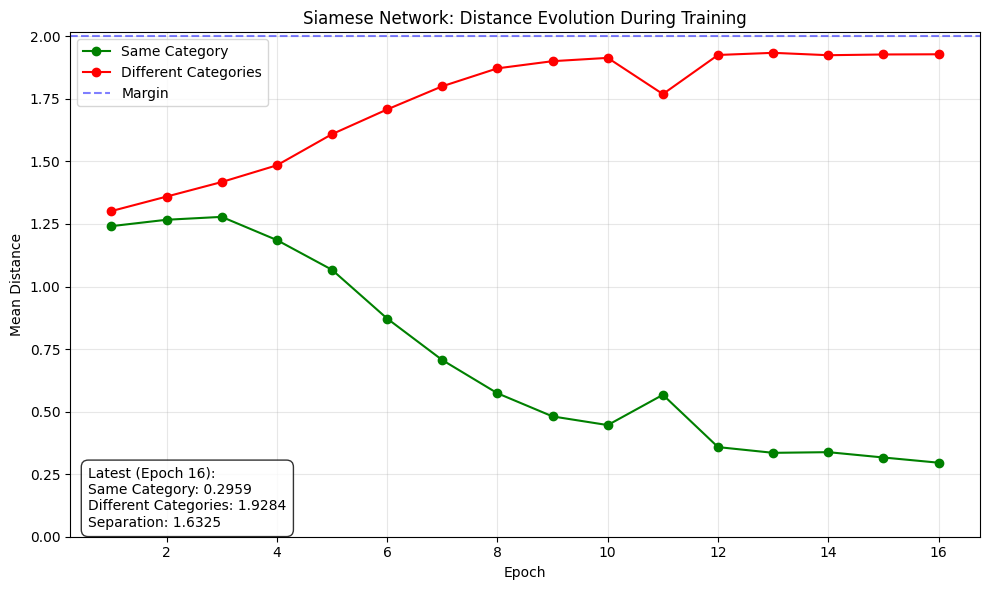

50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 728ms/step - accuracy: 0.5517 - loss: 0.5989 - val_accuracy: 0.9750 - val_loss: 0.1449 - learning_rate: 5.8682e-05
Epoch 17/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.5155 - loss: 0.6226
Epoch 17: Separation = 1.6417, Pos = 0.2819, Neg = 1.9236

Epoch 17: val_loss improved from 0.14488 to 0.14050, saving model to best_siamese_model.h5



Epoch 17 - Mean distances: Positive = 0.2819, Negative = 1.9236, Separation = 1.6417


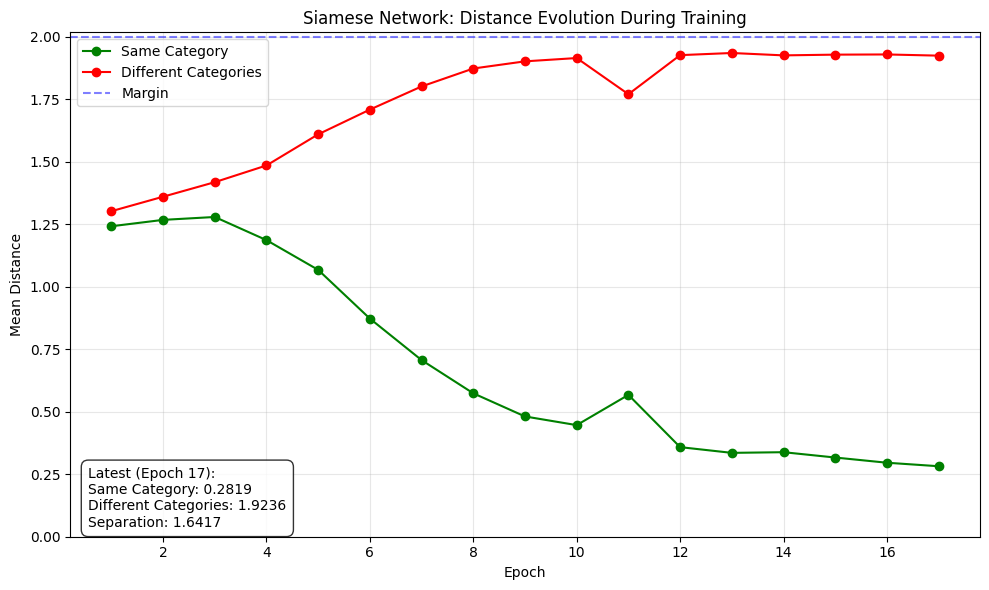

50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 686ms/step - accuracy: 0.5157 - loss: 0.6216 - val_accuracy: 0.9875 - val_loss: 0.1405 - learning_rate: 5.2907e-05
Epoch 18/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.5430 - loss: 0.5700
Epoch 18: Separation = 1.6398, Pos = 0.2803, Neg = 1.9200

Epoch 18: val_loss did not improve from 0.14050

Epoch 18 - Mean distances: Positive = 0.2803, Negative = 1.9200, Separation = 1.6398


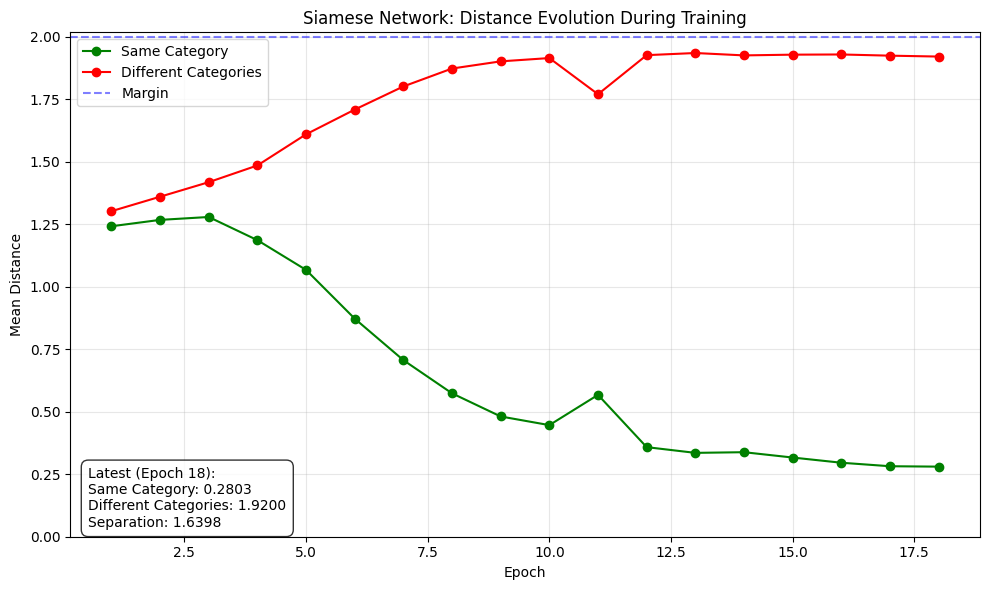

50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 678ms/step - accuracy: 0.5427 - loss: 0.5699 - val_accuracy: 0.9750 - val_loss: 0.1443 - learning_rate: 4.7093e-05
Epoch 19/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.5667 - loss: 0.5506
Epoch 19: Separation = 1.6634, Pos = 0.2613, Neg = 1.9248

Epoch 19: val_loss improved from 0.14050 to 0.13310, saving model to best_siamese_model.h5



Epoch 19 - Mean distances: Positive = 0.2613, Negative = 1.9248, Separation = 1.6634


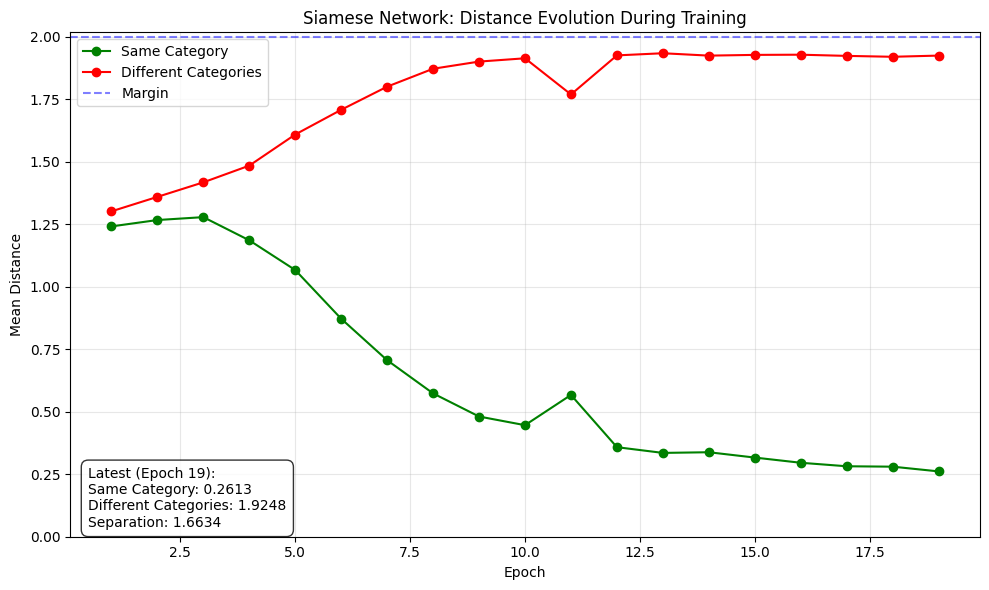

50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 645ms/step - accuracy: 0.5665 - loss: 0.5513 - val_accuracy: 0.9875 - val_loss: 0.1331 - learning_rate: 4.1318e-05
Epoch 20/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.5527 - loss: 0.5368
Epoch 20: Separation = 1.6246, Pos = 0.2776, Neg = 1.9022

Epoch 20: val_loss did not improve from 0.13310

Epoch 20 - Mean distances: Positive = 0.2776, Negative = 1.9022, Separation = 1.6246


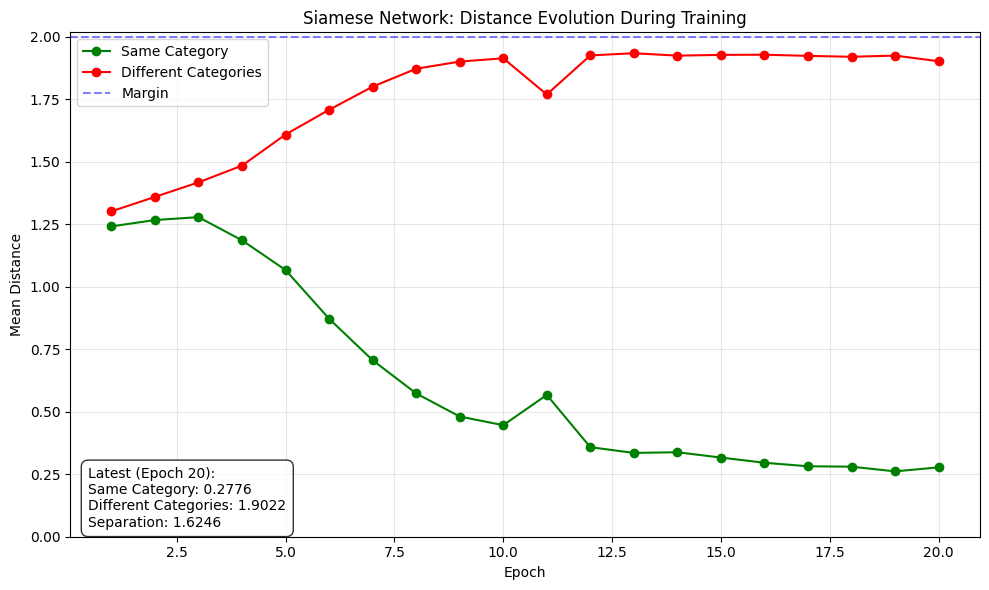

50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 613ms/step - accuracy: 0.5525 - loss: 0.5370 - val_accuracy: 0.9875 - val_loss: 0.1582 - learning_rate: 3.5660e-05
Epoch 21/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.5370 - loss: 0.5421
Epoch 21: Separation = 1.6846, Pos = 0.2422, Neg = 1.9268

Epoch 21: val_loss improved from 0.13310 to 0.12855, saving model to best_siamese_model.h5



Epoch 21 - Mean distances: Positive = 0.2422, Negative = 1.9268, Separation = 1.6846


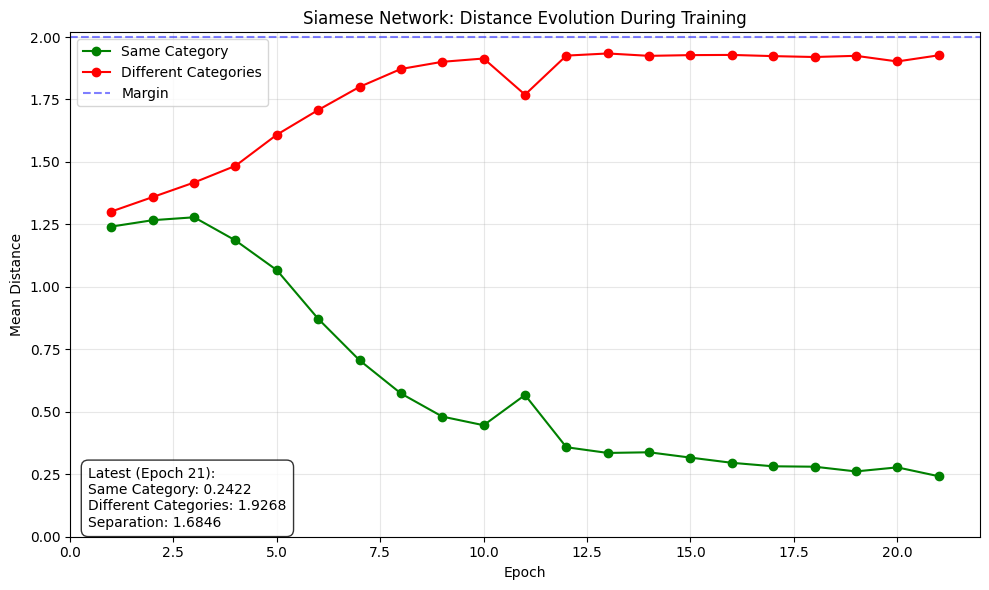

50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 744ms/step - accuracy: 0.5373 - loss: 0.5426 - val_accuracy: 0.9875 - val_loss: 0.1285 - learning_rate: 3.0196e-05
Epoch 22/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.5744 - loss: 0.5214
Epoch 22: Separation = 1.6697, Pos = 0.2543, Neg = 1.9240

Epoch 22: val_loss did not improve from 0.12855

Epoch 22 - Mean distances: Positive = 0.2543, Negative = 1.9240, Separation = 1.6697


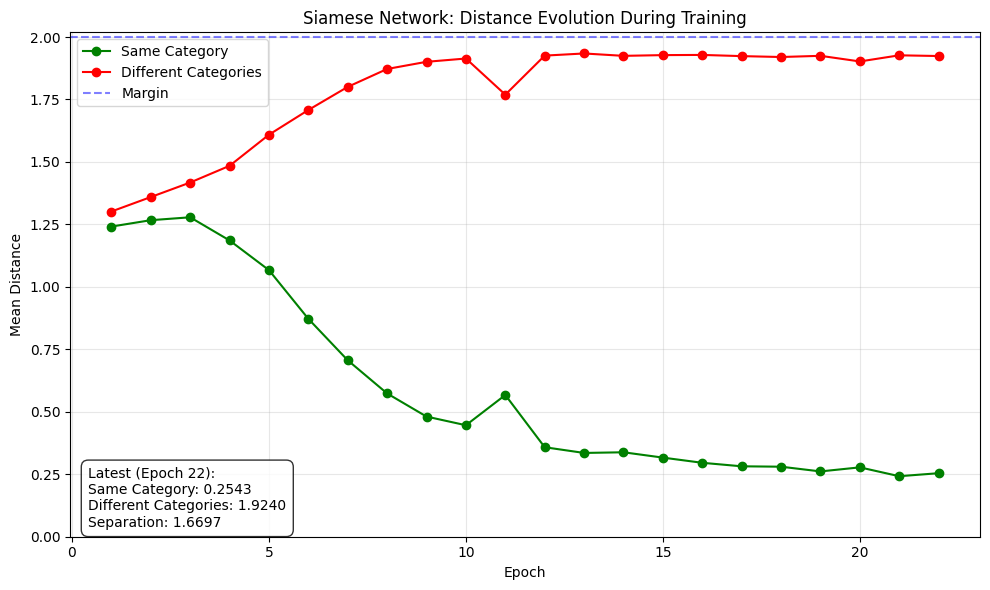

50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 669ms/step - accuracy: 0.5742 - loss: 0.5213 - val_accuracy: 0.9875 - val_loss: 0.1325 - learning_rate: 2.5000e-05
Epoch 23/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.5505 - loss: 0.4692
Epoch 23: Separation = 1.6750, Pos = 0.2466, Neg = 1.9216

Epoch 23: val_loss did not improve from 0.12855

Epoch 23 - Mean distances: Positive = 0.2466, Negative = 1.9216, Separation = 1.6750


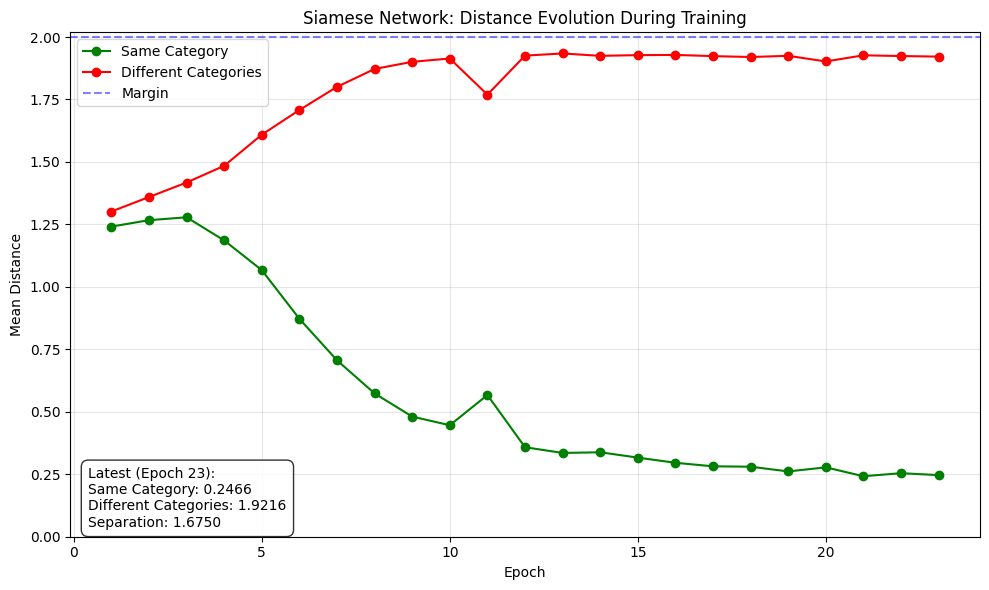

50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 674ms/step - accuracy: 0.5507 - loss: 0.4697 - val_accuracy: 0.9875 - val_loss: 0.1314 - learning_rate: 2.0142e-05
Epoch 24/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.5853 - loss: 0.4715
Epoch 24: Separation = 1.6938, Pos = 0.2345, Neg = 1.9283

Epoch 24: val_loss improved from 0.12855 to 0.12581, saving model to best_siamese_model.h5



Epoch 24 - Mean distances: Positive = 0.2345, Negative = 1.9283, Separation = 1.6938


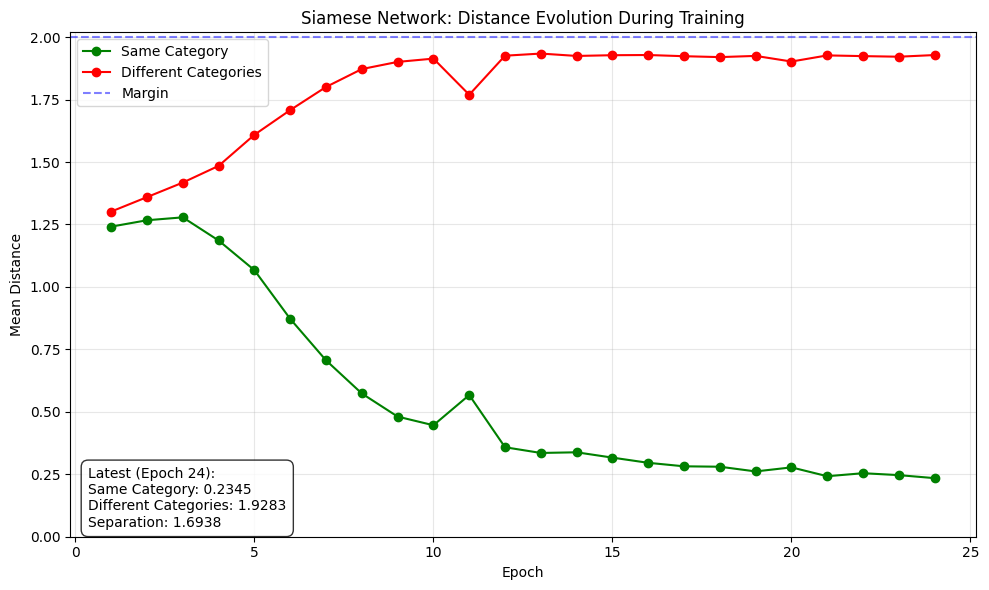

50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 762ms/step - accuracy: 0.5854 - loss: 0.4719 - val_accuracy: 0.9875 - val_loss: 0.1258 - learning_rate: 1.5688e-05
Epoch 25/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.5819 - loss: 0.4914
Epoch 25: Separation = 1.7049, Pos = 0.2264, Neg = 1.9313

Epoch 25: val_loss improved from 0.12581 to 0.12325, saving model to best_siamese_model.h5



Epoch 25 - Mean distances: Positive = 0.2264, Negative = 1.9313, Separation = 1.7049


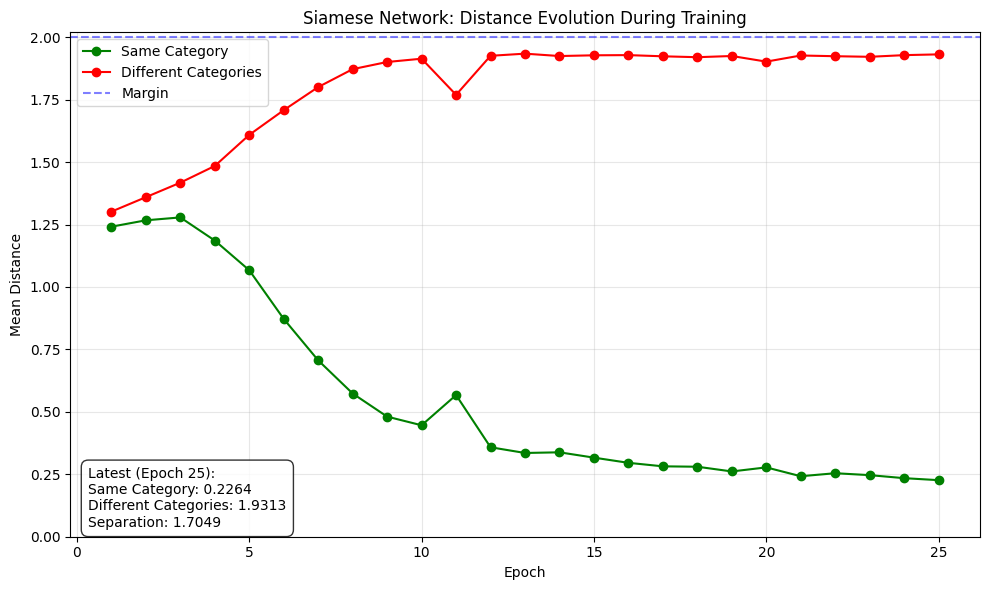

50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 698ms/step - accuracy: 0.5817 - loss: 0.4918 - val_accuracy: 1.0000 - val_loss: 0.1233 - learning_rate: 1.1698e-05
Epoch 26/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5693 - loss: 0.5268
Epoch 26: Separation = 1.7000, Pos = 0.2292, Neg = 1.9292

Epoch 26: val_loss did not improve from 0.12325

Epoch 26 - Mean distances: Positive = 0.2292, Negative = 1.9292, Separation = 1.7000


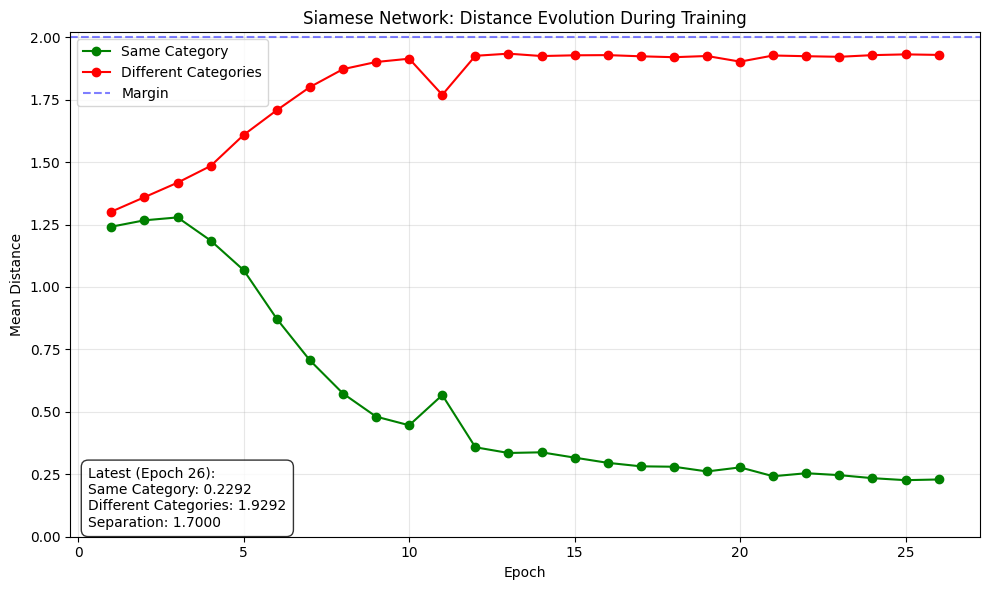

50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 554ms/step - accuracy: 0.5693 - loss: 0.5268 - val_accuracy: 0.9875 - val_loss: 0.1245 - learning_rate: 8.2256e-06
Epoch 27/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.5867 - loss: 0.4875
Epoch 27: Separation = 1.6967, Pos = 0.2330, Neg = 1.9297

Epoch 27: val_loss did not improve from 0.12325

Epoch 27 - Mean distances: Positive = 0.2330, Negative = 1.9297, Separation = 1.6967


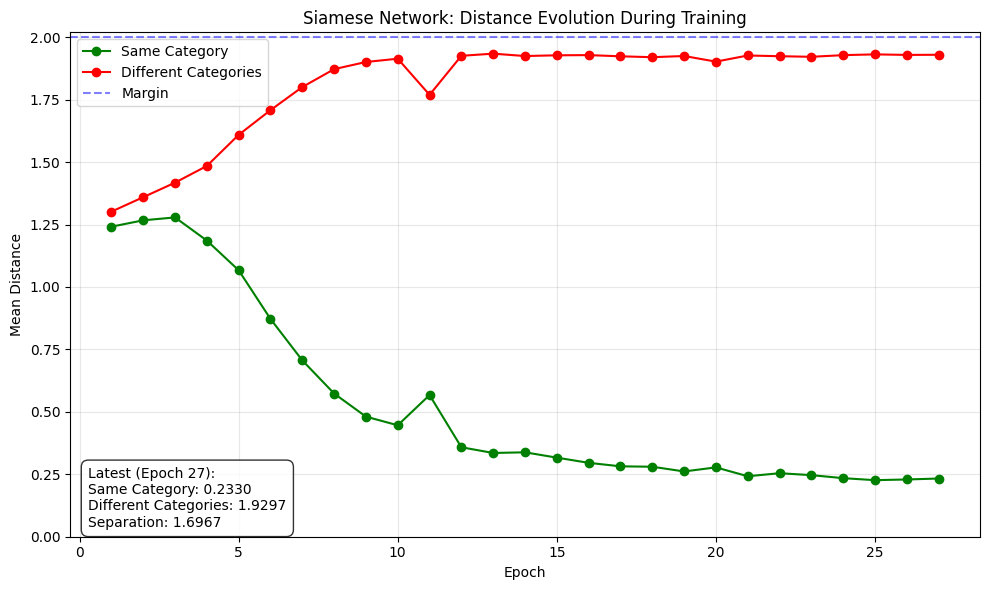

50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 699ms/step - accuracy: 0.5867 - loss: 0.4877 - val_accuracy: 0.9875 - val_loss: 0.1267 - learning_rate: 5.3184e-06
Epoch 28/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.5823 - loss: 0.4394
Epoch 28: Separation = 1.6943, Pos = 0.2334, Neg = 1.9277

Epoch 28: val_loss did not improve from 0.12325

Epoch 28 - Mean distances: Positive = 0.2334, Negative = 1.9277, Separation = 1.6943


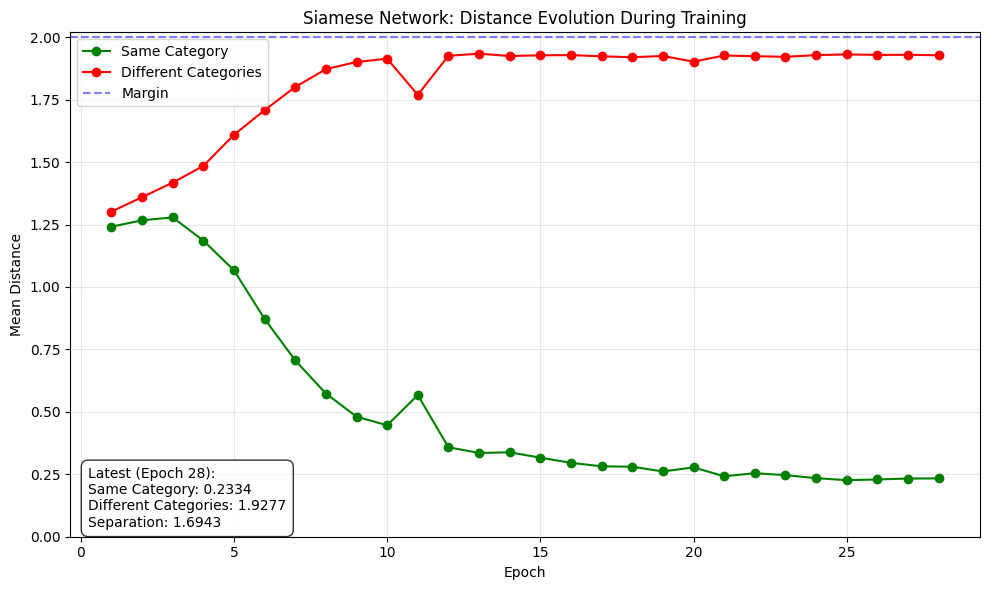

50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 746ms/step - accuracy: 0.5825 - loss: 0.4397 - val_accuracy: 0.9875 - val_loss: 0.1260 - learning_rate: 3.0154e-06
Epoch 29/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.5681 - loss: 0.5100
Epoch 29: Separation = 1.6975, Pos = 0.2307, Neg = 1.9282

Epoch 29: val_loss did not improve from 0.12325

Epoch 29 - Mean distances: Positive = 0.2307, Negative = 1.9282, Separation = 1.6975


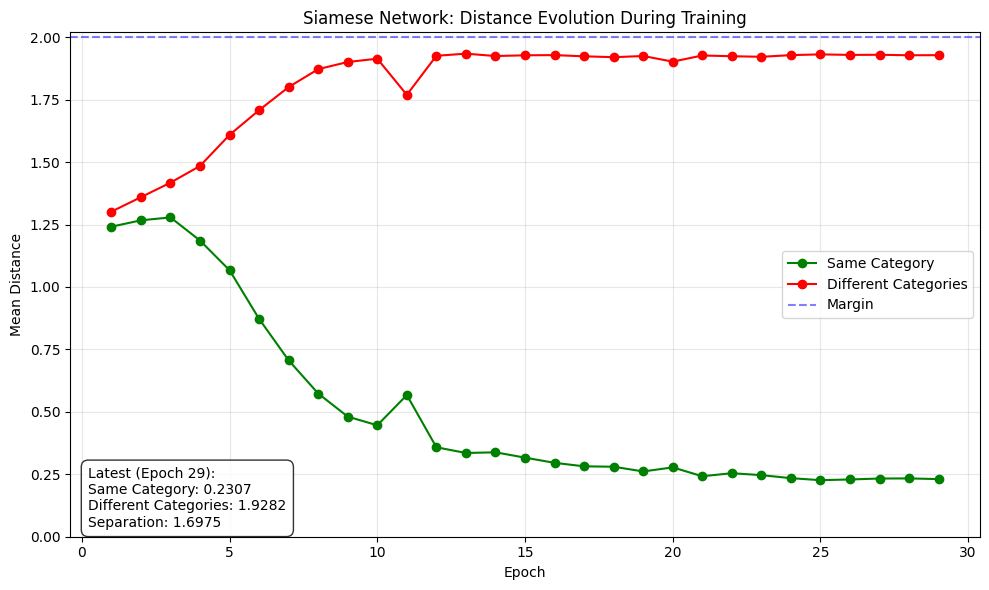

50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 675ms/step - accuracy: 0.5684 - loss: 0.5096 - val_accuracy: 0.9875 - val_loss: 0.1251 - learning_rate: 1.3478e-06
Epoch 30/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.5838 - loss: 0.4705
Epoch 30: Separation = 1.7046, Pos = 0.2275, Neg = 1.9321

Epoch 30: val_loss did not improve from 0.12325

Epoch 30 - Mean distances: Positive = 0.2275, Negative = 1.9321, Separation = 1.7046


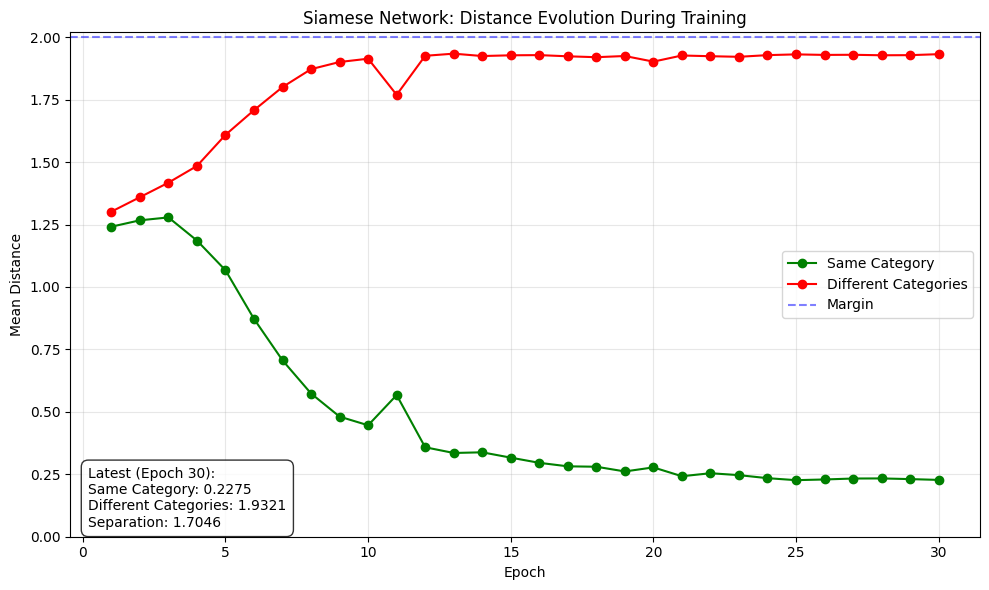

50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 738ms/step - accuracy: 0.5841 - loss: 0.4707 - val_accuracy: 0.9875 - val_loss: 0.1238 - learning_rate: 3.3808e-07
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 737ms/step - accuracy: 0.9528 - loss: 0.2745
Test accuracy: 0.9500


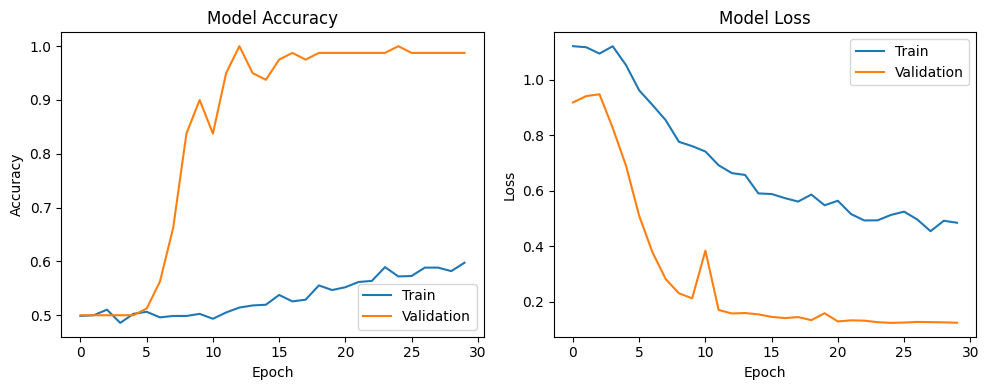

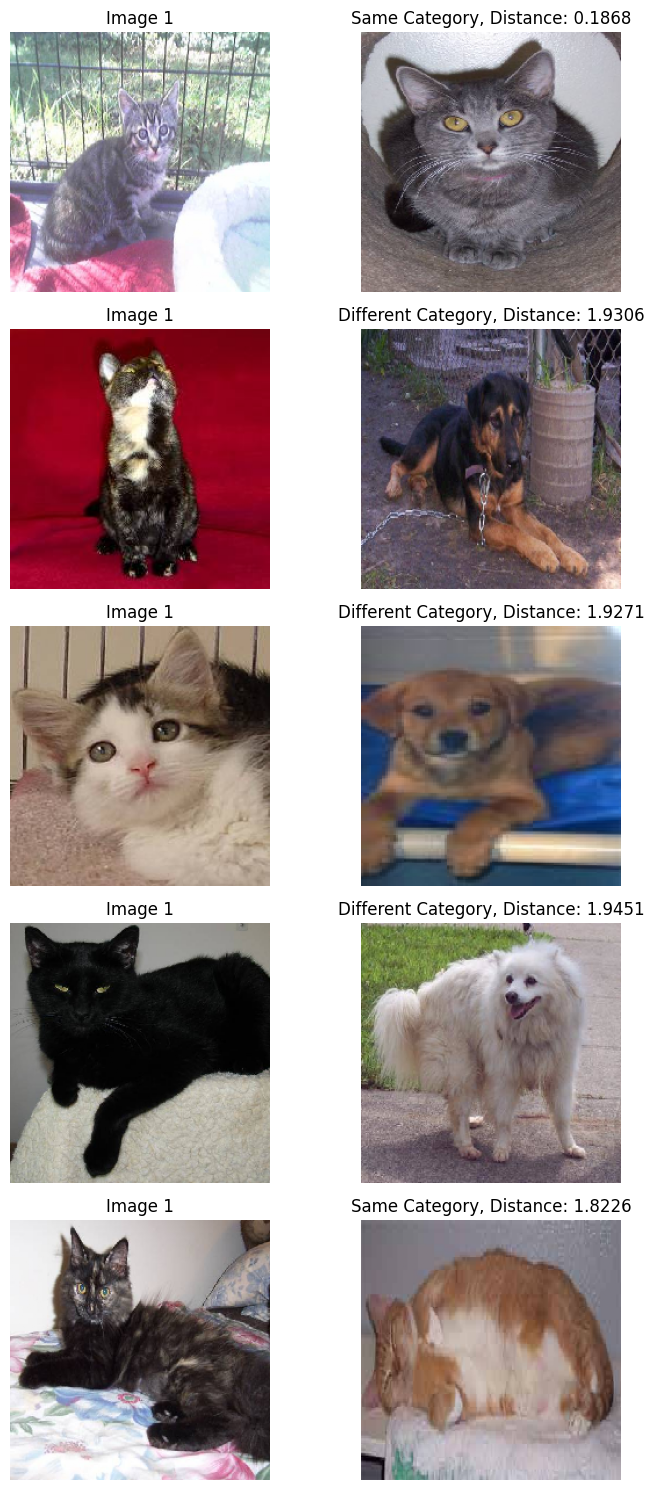

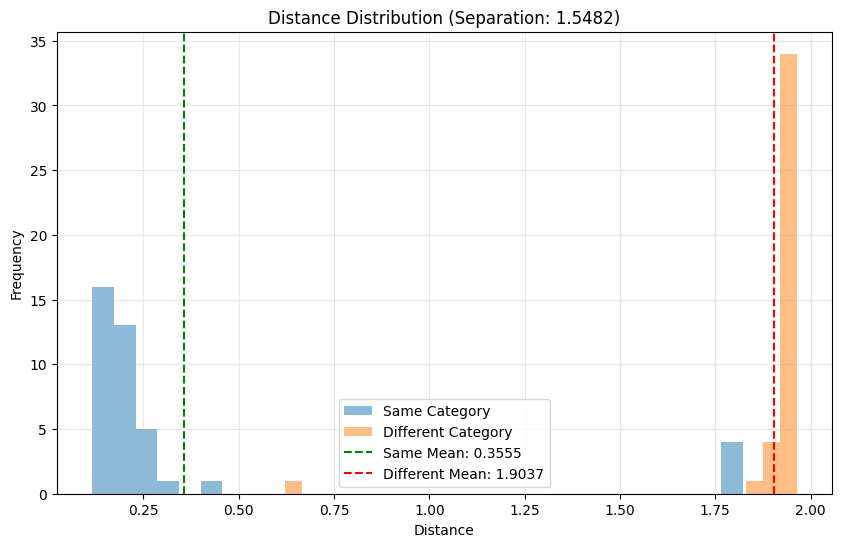

Distance Separation Analysis:
  Mean Same Category Distance: 0.3555
  Mean Different Category Distance: 1.9037
  Separation: 1.5482
Improved Siamese Network implementation complete!


In [ ]:

# Improved Image Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,           # Increased from 20
    width_shift_range=0.3,       # Increased from 0.2
    height_shift_range=0.3,      # Increased from 0.2
    brightness_range=[0.7, 1.3], # Add brightness variation
    zoom_range=0.3,              # Increased from 0.2
    horizontal_flip=True,
    shear_range=0.2,             # Add shear for more variation
    fill_mode="nearest"
)

# Only rescaling for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load image paths - updated to use appropriate size for each set
image_paths = {
    set_name: {
        cat: get_image_paths(
            set_name,
            cat,
            TRAIN_SIZE if set_name == "train" else VAL_SIZE if set_name == "Validation" else TEST_SIZE
        ) for cat in categories
    } for set_name in sets
}

# Create datasets with appropriate batch size
BATCH_SIZE = 16
train_dataset, train_steps = create_improved_siamese_dataset(
    image_paths["train"], batch_size=BATCH_SIZE, datagen=train_datagen, is_training=True
)
val_dataset, val_steps = create_improved_siamese_dataset(
    image_paths["Validation"], batch_size=BATCH_SIZE, datagen=None, is_training=False
)
test_dataset, test_steps = create_improved_siamese_dataset(
    image_paths["test"], batch_size=BATCH_SIZE, datagen=None, is_training=False
)


# Show some processed training pairs
show_image_pairs_from_dataset(train_dataset)

# Force garbage collection before building the model
gc.collect()




# Build the Siamese model
input_shape = (224, 224, 3)
embedding_network = build_siamese_network(input_shape)

# Create the Siamese architecture
input_1 = keras.layers.Input(input_shape)
input_2 = keras.layers.Input(input_shape)

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

# Calculate Euclidean distance between embeddings
distance = keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])

# IMPROVED: Removed sigmoid activation to get raw distances
siamese_network = keras.Model(inputs=[input_1, input_2], outputs=distance)

# Compile with better learning rate and the improved contrastive loss
optimizer = keras.optimizers.Adam(learning_rate=1e-4)  # Reduced learning rate for better convergence
siamese_network.compile(
    loss=contrastive_loss(margin=1.5),  # Increased margin
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Print model summary
siamese_network.summary()


# Set up training parameters
steps_per_epoch = 50  # Fixed number of steps per epoch for consistent training
validation_steps = 20  # Fixed number of validation steps

# Increase epochs for better convergence with early stopping
EPOCHS = 30

# Create improved callbacks
callbacks = [
    # Custom early stopping based on distance separation
    DistanceSeparationEarlyStopping(val_dataset, patience=7, min_separation=0.7),

    # Learning rate schedule with warm-up
    create_lr_schedule(),

    # Checkpoint to save the best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_siamese_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),

    # Distance tracker for monitoring
    DistanceTracker(val_dataset, num_batches=5)
]

# Train the model with memory optimizations
history = siamese_network.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Force garbage collection
gc.collect()

# Evaluate on test set
test_loss, test_acc = siamese_network.evaluate(test_dataset, steps=min(test_steps, 20))
print(f"Test accuracy: {test_acc:.4f}")


# Plot training history
plot_training_history(history)


# Show test predictions with distances
show_test_predictions(test_dataset, siamese_network)



# Plot distance distribution on test set
plot_distance_distribution(test_dataset, siamese_network)

# Clean up to free memory
gc.collect()
print("Improved Siamese Network implementation complete!")